<a href="https://colab.research.google.com/github/SoroushJamali/Deepfake-Audio-Detection/blob/main/COMPLETE_Bichoher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper DOI : https://doi.org/10.48550/arXiv.1811.02973

**Bicoherence analysis of nonstationary and nonlinear
processes**


Bicoherence analysis is a well established method
for identifying the quadratic nonlinearity of stationary processes.
However, it is often applied without checking the basic assumptions of stationarity and convergence. The classic bicoherence,
unfortunately, tends to give false positives – high bicoherence
values without actual nonlinear coupling of different frequency
components – for signals exhibiting rapidly changing amplitudes
and limited length. The effect of false positive values can lead to
misinterpretation of results, therefore a more prudent analysis
is necessary in such cases. This paper analyses the properties
of bispectrum and bicoherence in detail, generalizing these
quantities to nonstationary processes. A step-by-step method is
proposed to filter out false positives at a given confidence level
for the case of nonstationary signals. We present a number of test
cases, where the method is demonstrated on simple physics-based
numerical systems. The approach and methodology introduced in
the paper can be generalized to lower and higher order coherence
calculations.


In the case of nonstationary processes, the length of the steps taken which depend on the Fourier amplitudes may vary. In the case of phase coupling, the vectors align in the same direction. Therefore the bicoherence value is high, similarly as for stationary signals.

# **Libereires**

In [ ]:
import sklearn  
from sklearn import preprocessing
import IPython.display as ipd
import scipy  
from scipy.stats import norm, kurtosis
from scipy.linalg import hankel
from scipy.fft import fft,fftshift
from scipy.stats import skew
from scipy import signal

import librosa, librosa.display
import numpy as np
import statistics
import math

import matplotlib.pyplot as plt
from pathlib import Path   



# **# Usefull Functions**

In [ ]:

all_true_var_ang = [0,0,0,0]
all_true_var_bic = [0,0,0,0]
all_true_std_ang = [0,0,0,0]
all_true_std_bic = [0,0,0,0]
all_true_skew_ang = [0,0,0,0]
all_true_skew_bic = [0,0,0,0]
all_true_kurtosis_ang = [0,0,0,0]
all_true_kurtosis_bic = [0,0,0,0]

all_fake_var_ang = [0,0,0,0]
all_fake_var_bic = [0,0,0,0]
all_fake_std_ang = [0,0,0,0]
all_fake_std_bic = [0,0,0,0]
all_fake_skew_ang = [0,0,0,0]
all_fake_skew_bic = [0,0,0,0]
all_fake_kurtosis_ang = [0,0,0,0]
all_fake_kurtosis_bic = [0,0,0,0]

In [ ]:
def next_power_of_2(x):
    return 1 if x == 0 else 2**math.ceil(math.log2(x))

In [ ]:
def normalizer(data):
  oldmin = min(data)
  oldmax = max(data)
  oldrange = oldmax - oldmin
  newmin = 0.
  newmax = 1.
  newrange = newmax - newmin
  if oldrange == 0:            # Deal with the case where rvalue is constant:
      if oldmin < newmin:      # If rvalue < newmin, set all rvalue values to newmin
         newval = newmin
      elif oldmin > newmax:    # If rvalue > newmax, set all rvalue values to newmax
          newval = newmax
      else:                    # If newmin <= rvalue <= newmax, keep rvalue the same
          newval = oldmin
      normal = [newval for v in data]
  else:
       scale = newrange / oldrange
       normal = [(v - oldmin) * scale + newmin for v in data]

  return normal
  

# **Bicoherence**

In [ ]:
#	[bic,waxis] = bicoher (y,  nfft, wind, segsamp, overlap)
#	y     - data vector or time-series
#	nfft - fft length [default = power of two > segsamp]
#	       actual size used is power of two greater than 'nsamp'
#	wind - specifies the time-domain window to be applied to each
#	       data segment; should be of length 'segsamp' (see below);
#		otherwise, the default Hanning window is used.
#	segsamp - samples per segment [default: such that we have 8 segments]
#	        - if x is a matrix, segsamp is set to the number of rows
#	overlap - percentage overlap, allowed range [0,99]. [default = 50];
#	        - if x is a matrix, overlap is set to 0.
#	bic     - estimated bicoherence: an nfft x nfft array, with origin
#	          at the center, and axes pointing down and to the right.
#	waxis   - vector of frequencies associated with the rows and columns
#	          of bic;  sampling frequency is assumed to be 1.
def bicoher(y,  nfft, winds, nsamp, overlap,normalization):

#--------------------parameter checks---------------------
  means = [0,0]
  ly = len(y)
  nrecs = 1
  if (ly == 1):
    y = (np.array(y)).reshape((-1, 1)) 
    ly = nrecs; 
    nrecs = 1;

  if nfft is None:
    nfft = 128

  if overlap is None:
    overlap = 50
  overlap = max(0,min(overlap,99))

  if nrecs > 1:  
    overlap = 0
  if nrecs > 1 :
    nsamp = ly
 
  if nrecs == 1 and nsamp <= 0:
    nsamp = np.fix(ly/ (8 - 7 * overlap/100))
  if nfft  < nsamp:
     nfft = 2^next_power_of_2(nsamp)

 
  overlap  = int(np.fix( nsamp * overlap/100))
  
  nadvance = nsamp - overlap
  nrecs    = int(np.fix ( (ly*nrecs - overlap) / nadvance))
  if winds is None:
     wind = np.hanning(nsamp)

  if winds == 'hann':
    wind = scipy.signal.hann(nsamp)
  elif winds == 'hamm':
    wind = scipy.signal.hamming(nsamp)
   

  rw = len(wind)
  cw = 1

  if min(rw,cw) != 1 or max(rw,cw) != nsamp:
	   print(['Segment size  is ',str(nsamp)])
	   print(['"wind" array  is ',str(rw),' by ',str(cw)])
	   print(['Using default Hanning window'])
	   wind = np.hanning(nsamp);
  

#---------------- accumulate triple products ----------------------
  bic  = np.zeros((nfft,nfft))
  Pyy  = np.zeros((1,nfft))
  Yf12 = np.zeros((nfft,nfft))
  ind  = np.array(np.arange(0,nsamp))

  for i in range(0, nrecs):
    ys = y[ind[0]:ind[-1]+1]
    ys = (ys- np.mean(ys))*wind
    Yf = np.array(fft(ys,nfft))/ nsamp
    CYf = np.conjugate(Yf)
    Pyy = Pyy + Yf * CYf
    CYf_shi = np.roll(CYf,1)
    Yf12 = hankel(CYf,CYf_shi)
    bic = bic + (Yf * Yf.reshape((-1, 1))) * Yf12
    ind = ind + nadvance
    
 
  bicc     = bic / nrecs
  angles=(sum(np.angle(bicc)))
  means[0] = np.mean(angles)
  X_mag,X_phase=librosa.magphase(fftshift(bicc)) 
  Pyy     = Pyy  / nrecs
  Pyy_shi = np.roll(Pyy,1)
  mask = hankel(Pyy,Pyy_shi)
    
  if normalization==1 : # -------- Defualt
    den = (Pyy * Pyy.reshape((-1, 1))*mask) 
    bic = abs(bicc)**2 /abs(den) 

  elif normalization == 2: #---------- papre
    den = (abs(Pyy * Pyy.reshape((-1, 1)))**2 * abs(mask)**2) 
    bic = (bicc) / np.sqrt(den) 

  elif normalization == 3:  # -------- 1 wiki
    den = pow(abs(Pyy),2) * pow(abs(Pyy.reshape((-1, 1))),2) * abs(mask)**2
    denn = pow(den,-2)
    bic = abs(bicc) / denn

  elif normalization == 4: # --------- 2 wiki
    den = (abs(Pyy * Pyy.reshape((-1, 1)))**2 * abs(mask)**2) 
    bic = abs(bicc)**2  / (den) 

  elif normalization == 5: # --------- 3 wiki
    den = abs(Pyy * Pyy.reshape((-1, 1)) * mask)
    bic = abs(bicc)  / (den) 
 

  biccc = fftshift(bic) 
  means[1] = np.mean(biccc)   

  var_ang  = np.var (angles)/means[1]
  var_bic  = np.var (biccc)/means[1]

  std_ang  = np.std (angles)
  std_bic  = np.std (biccc)

  skew_ang = skew(angles)
  skew_bic = skew(np.sum(biccc))

  kurtosis_ang = kurtosis(angles)
  kurtosis_bic = kurtosis(np.sum(biccc))

  statistic = [var_ang,var_bic,std_ang,std_bic,skew_ang,skew_bic,kurtosis_ang,kurtosis_bic]

  den = (Pyy * Pyy.reshape((-1, 1))*mask) 
  bic = abs(bicc)**2 /abs(den)
  means[1] = np.mean(bic)
  biccc = fftshift(bic) 

  return angles,bic,means,statistic

# X^2 **Nonlinearity**

# **Signal generation**

In [ ]:
fs = 44100
N = 1e4
time = np.arange(N) / float(fs)
x =  -np.sin(2*np.pi*40*time ) 
noise_volts = np.random.normal(0, .05, len(x))
x=x+noise_volts
X = x**2+x

# **Testing parameters**

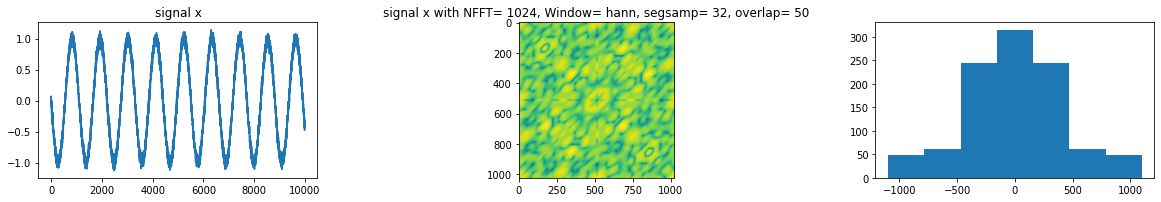

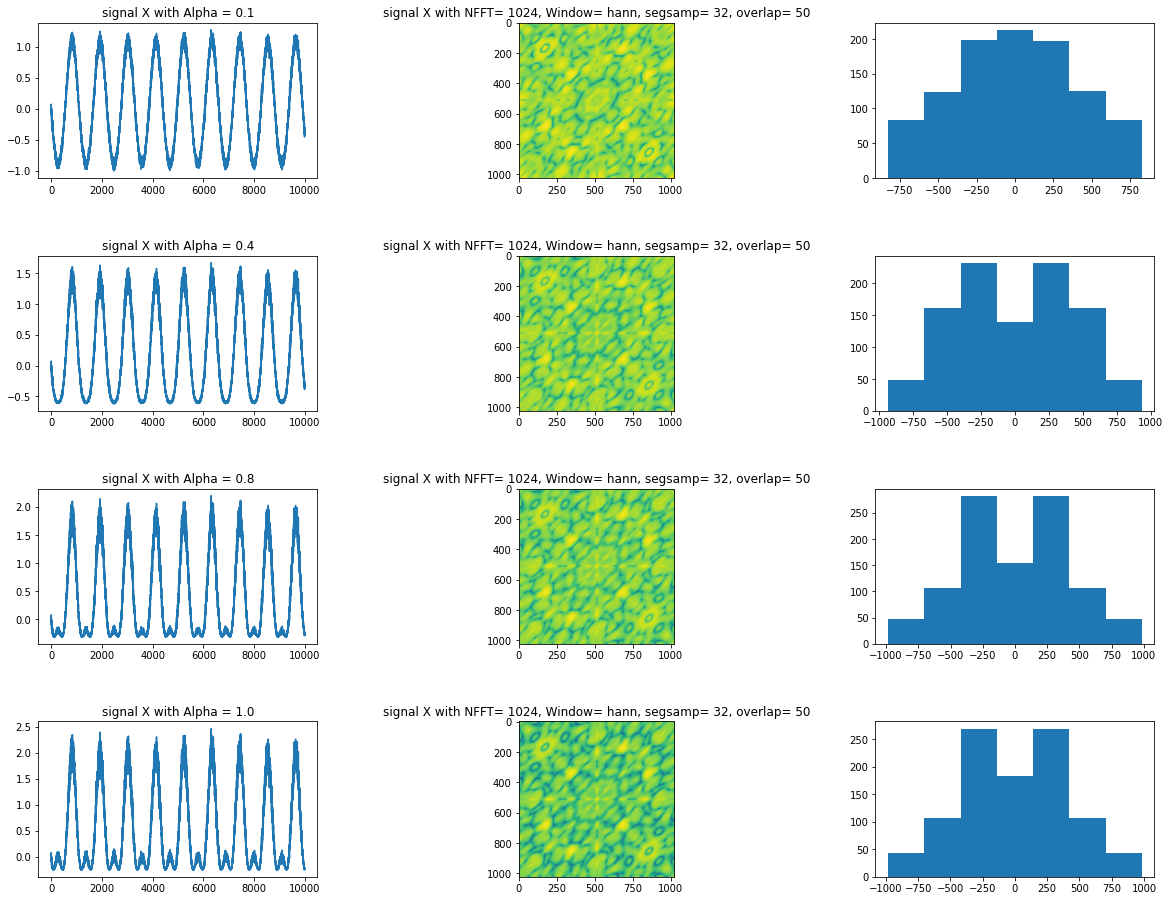

In [ ]:
# ---------------- Params
#	[bic,waxis] = bicoher (y,  nfft, wind, segsamp, overlap)

#nfft = [64, 128, 512, 1024,2048]  
#wind = ['hann', 'hamm']
#segsamp = [64,128,256,512]
#overlap  = [30,50,70]
nfft = [1024]  
wind = ['hann']
segsamp = [32]
overlap  = [50]
alpha = np.array([.1,.4,.8,1])
subn = len(alpha)+1
## ---------- Plots -----------------
subp = -1
plt.figure(figsize=(20,20))
for i in range(0, len(nfft)):
  for j in range(0, len(wind)):
    for k in range(0, len(segsamp)):
      for o in range(0, len(overlap)):
        plt.subplot(subn,3,1)
        plt.plot(x)
        plt.title('signal x')
        subp = 1 + subp
        anglez_x,bic_x,meansx,statistic_x= bicoher(x,nfft[i],wind[j],segsamp[k],overlap[o],21)
        plt.subplot(subn,3,2)
        plt.imshow(20*np.log10(abs(fftshift(bic_x))))
        plt.title('signal x with NFFT= {}'.format(nfft[i]) + ', Window= {}'.format(wind[j]) + ', segsamp= {}'.format(segsamp[k]) + ', overlap= {}'.format(overlap[o]))
        plt.subplot(subn,3,3)
        plt.hist(anglez_x,7)
        plt.subplots_adjust(hspace=0.5)
        plt.subplots_adjust(wspace=0.5)

plt.figure(figsize=(20,20))
for hhh in range(0, len(alpha)):
  for i in range(0, len(nfft)):
    for j in range(0, len(wind)):
      for k in range(0, len(segsamp)):
        for o in range(0, len(overlap)):
          X = alpha[hhh]*x**2+x
          subp=subp+3
          plt.subplot(subn,3,subp+1)
          plt.plot(X)
          plt.title('signal X with Alpha = {}'.format(alpha[hhh]))
          anglez_X,bic_x,meansX,statistic_X= bicoher(X,nfft[i],wind[j],segsamp[k],overlap[o],2)
          plt.subplot(subn,3,subp+2)
          plt.imshow(20*np.log10(abs(fftshift(bic_x))))
          plt.title('signal X with NFFT= {}'.format(nfft[i]) + ', Window= {}'.format(wind[j]) + ', segsamp= {}'.format(segsamp[k]) + ', overlap= {}'.format(overlap[o]))
          plt.subplot(subn,3,subp+3)
          plt.subplots_adjust(hspace=0.5)
          plt.subplots_adjust(wspace=0.5)
          plt.hist(anglez_X,7)

In [ ]:
all_true_var_ang[0] = statistic_x[0]
all_true_var_bic[0] = statistic_x[1]
all_true_std_ang[0] = statistic_x[2]
all_true_std_bic[0] = statistic_x[3]
all_true_skew_ang[0] = statistic_x[4]
all_true_skew_bic[0] = statistic_x[5]
all_true_kurtosis_ang[0] = statistic_x[6]
all_true_kurtosis_bic[0] = statistic_x[7]

all_fake_var_ang[0] = statistic_X[0]
all_fake_var_bic[0] = statistic_X[1]
all_fake_std_ang[0] = statistic_X[2]
all_fake_std_bic[0] = statistic_X[3]
all_fake_skew_ang[0] = statistic_X[4]
all_fake_skew_bic[0] = statistic_X[5]
all_fake_kurtosis_ang[0] = statistic_X[6]
all_fake_kurtosis_bic[0] = statistic_X[7]

In [ ]:
print('var_ang')
print('x = ',statistic_x[0], 'X = ',statistic_X[0])
print('var_bic')
print('x = ',statistic_x[1],  'X = ',statistic_X[1])
print('std_ang' )
print('x = ',statistic_x[2],  'X = ',statistic_X[2])
print('std_bic')
print('x = ',statistic_x[3], 'X = ',statistic_X[3])
print('skew_ang')
print('x  = ',statistic_x[4], 'X = ',statistic_X[4])
print('skew_bic')
print('x = ',statistic_x[5], 'X = ',statistic_X[5])
print('kurtosis_ang')
print('x = ',statistic_x[6], 'X = ',statistic_X[6])
print('kurtosis_bic')
print('x = ',statistic_x[7], 'X = ',statistic_X[7])

var_ang
x =  2.593385984869952e+66 X =  3.8887906575977346e+60
var_bic
x =  2.6301122967648425e-59 X =  3.684465888304341e-54
std_ang
x =  551.3319222212926 X =  416.0172904721446
std_bic
x =  1.7557662842493177e-60 X =  4.0494064360396556e-55
skew_ang
x  =  0.0023669218646073945 X =  -0.0002632391651012852
skew_bic
x =  0.0 X =  0.0
kurtosis_ang
x =  -0.5602102864314409 X =  -0.8319197353086549
kurtosis_bic
x =  -3.0 X =  -3.0


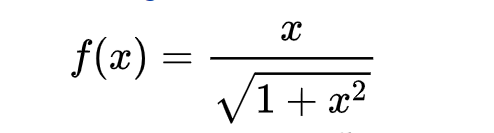

In [ ]:
X = x / np.sqrt(1+x**2)

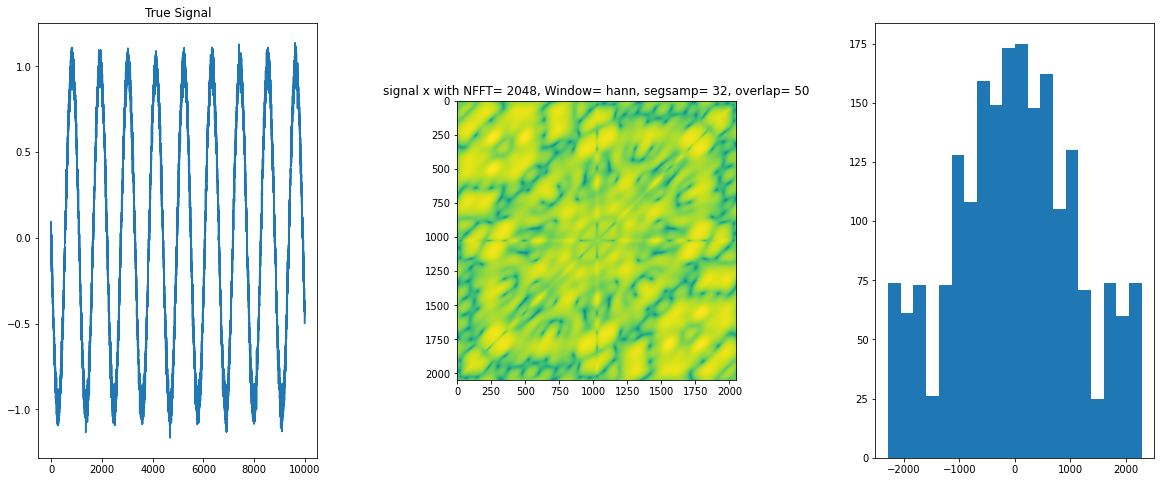

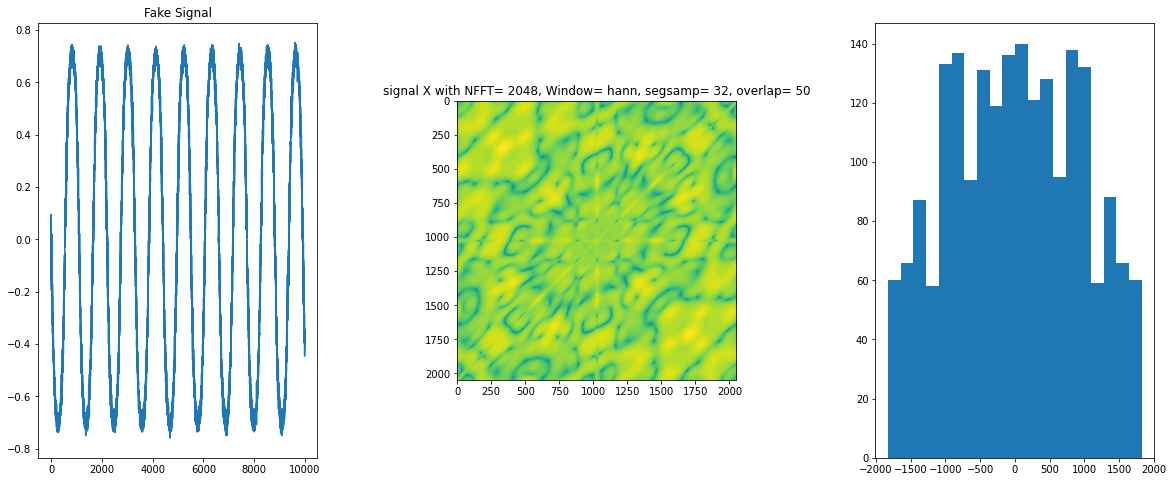

In [ ]:
#nfft = [64, 128, 512, 1024,2048]  
#wind = ['hann', 'hamm']
#segsamp = [64,128,256,512]
#overlap  = [30,50,70]
nfft = [2048]  
wind = ['hann']
segsamp = [32]
overlap  = [50]
subn=2
subp=3
## ---------- Plots -----------------
plt.figure(figsize=(20,20))
for i in range(0, len(nfft)):
  for j in range(0, len(wind)):
    for k in range(0, len(segsamp)):
      for o in range(0, len(overlap)):
        plt.subplot(subn,3,1)
        plt.plot(x)
        plt.title('True Signal')
        subp = 1 + subp
        anglez_x,bic_x,meansx,statistic_x= bicoher(x,nfft[i],wind[j],segsamp[k],overlap[o],3)
        plt.subplot(subn,3,2)
        plt.imshow(20*np.log10(abs(fftshift(bic_x))))
        plt.title('signal x with NFFT= {}'.format(nfft[i]) + ', Window= {}'.format(wind[j]) + ', segsamp= {}'.format(segsamp[k]) + ', overlap= {}'.format(overlap[o]))
        plt.subplot(subn,3,3)
        plt.hist(anglez_x,20)
        plt.subplots_adjust(hspace=0.5)
        plt.subplots_adjust(wspace=0.5)

plt.figure(figsize=(20,20))
for i in range(0, len(nfft)):
  for j in range(0, len(wind)):
    for k in range(0, len(segsamp)):
      for o in range(0, len(overlap)):
          plt.subplot(subn,3,4)
          plt.plot(X)
          plt.title('Fake Signal')
          anglez_X,bic_X,meansX,statistic_X= bicoher(X,nfft[i],wind[j],segsamp[k],overlap[o],3)
          plt.subplot(subn,3,5)
          plt.imshow(20*np.log10(abs(fftshift(bic_X))))
          plt.title('signal X with NFFT= {}'.format(nfft[i]) + ', Window= {}'.format(wind[j]) + ', segsamp= {}'.format(segsamp[k]) + ', overlap= {}'.format(overlap[o]))
          plt.subplot(subn,3,6)
          plt.subplots_adjust(hspace=0.5)
          plt.subplots_adjust(wspace=0.5)
          plt.hist(anglez_X,20)

In [ ]:
all_true_var_ang[1] = statistic_x[0]
all_true_var_bic[1] = statistic_x[1]
all_true_std_ang[1] = statistic_x[2]
all_true_std_bic[1] = statistic_x[3]
all_true_skew_ang[1] = statistic_x[4]
all_true_skew_bic[1] = statistic_x[5]
all_true_kurtosis_ang[1] = statistic_x[6]
all_true_kurtosis_bic[1] = statistic_x[7]

all_fake_var_ang[1] = statistic_X[0]
all_fake_var_bic[1] = statistic_X[1]
all_fake_std_ang[1] = statistic_X[2]
all_fake_std_bic[1] = statistic_X[3]
all_fake_skew_ang[1] = statistic_X[4]
all_fake_skew_bic[1] = statistic_X[5]
all_fake_kurtosis_ang[1] = statistic_X[6]
all_fake_kurtosis_bic[1] = statistic_X[7]

In [ ]:
print('var_ang')
print('         x = ',statistic_x[0], 'X = ',statistic_X[0])
print('var_bic')
print('         x = ',statistic_x[1],  'X = ',statistic_X[1])
print('std_ang' )
print('         x = ',statistic_x[2],  'X = ',statistic_X[2])
print('std_bic')
print('         x = ',statistic_x[3], 'X = ',statistic_X[3])
print('skew_ang')
print('         x  = ',statistic_x[4], 'X = ',statistic_X[4])
print('skew_bic')
print('         x = ',statistic_x[5], 'X = ',statistic_X[5])
print('kurtosis_ang')
print('         x = ',statistic_x[6], 'X = ',statistic_X[6])
print('kurtosis_bic')
print('         x = ',statistic_x[7], 'X = ',statistic_X[7])

var_ang
         x =  1.0377126008340097e+67 X =  2.97278112567638e+70
var_bic
         x =  2.6301123136132063e-59 X =  9.702382207997179e-63
std_ang
         x =  1102.8542038938253 X =  929.8241847757968
std_bic
         x =  1.755766284298995e-60 X =  5.312006037555999e-64
skew_ang
         x  =  0.0011880563567865253 X =  0.0006586597762656198
skew_bic
         x =  0.0 X =  0.0
kurtosis_ang
         x =  -0.5588981450314936 X =  -0.9563320255171361
kurtosis_bic
         x =  -3.0 X =  -3.0


# **tanh**

In [ ]:
X = np.tanh(x)

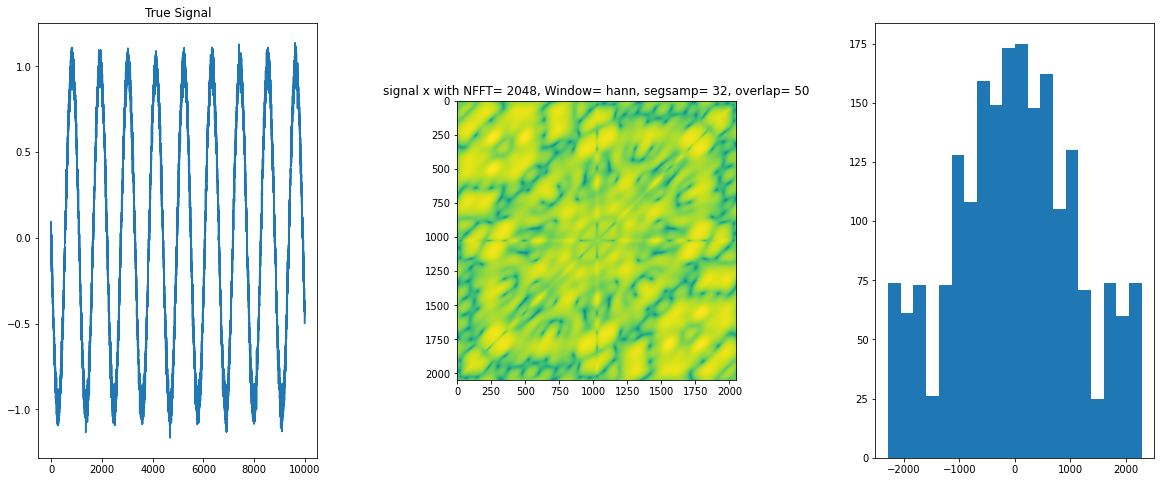

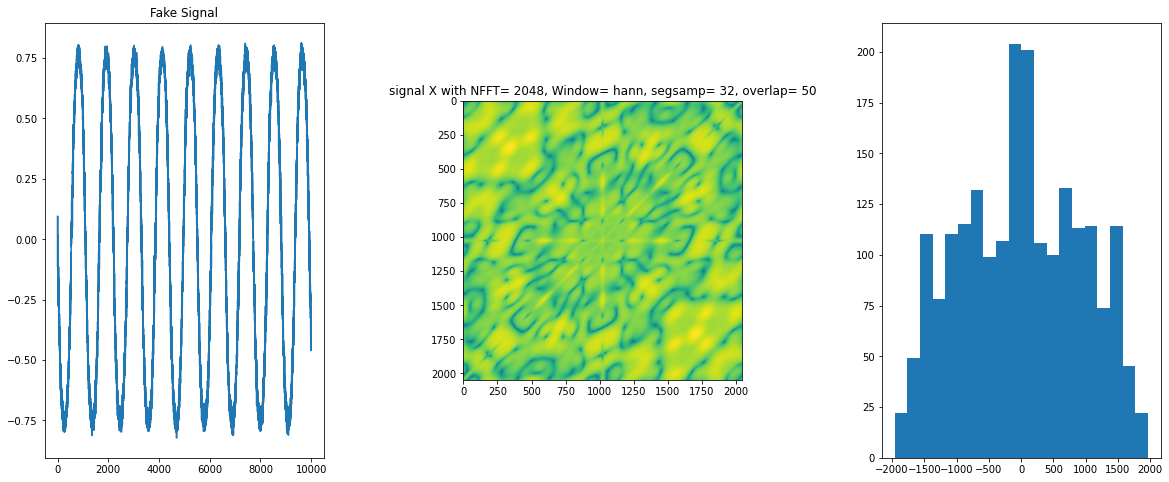

In [ ]:
#nfft = [64, 128, 512, 1024,2048]  
#wind = ['hann', 'hamm']
#segsamp = [64,128,256,512]
#overlap  = [30,50,70]
nfft = [2048]  
wind = ['hann']
segsamp = [32]
overlap  = [50]
subn=2
subp=3
## ---------- Plots -----------------
plt.figure(figsize=(20,20))
for i in range(0, len(nfft)):
  for j in range(0, len(wind)):
    for k in range(0, len(segsamp)):
      for o in range(0, len(overlap)):
        plt.subplot(subn,3,1)
        plt.plot(x)
        plt.title('True Signal')
        subp = 1 + subp
        anglez_x,bic_x,meansx,statistic_x= bicoher(x,nfft[i],wind[j],segsamp[k],overlap[o],3)
        plt.subplot(subn,3,2)
        plt.imshow(20*np.log10(abs(fftshift(bic_x))))
        plt.title('signal x with NFFT= {}'.format(nfft[i]) + ', Window= {}'.format(wind[j]) + ', segsamp= {}'.format(segsamp[k]) + ', overlap= {}'.format(overlap[o]))
        plt.subplot(subn,3,3)
        plt.hist(anglez_x,20)
        plt.subplots_adjust(hspace=0.5)
        plt.subplots_adjust(wspace=0.5)

plt.figure(figsize=(20,20))
for i in range(0, len(nfft)):
  for j in range(0, len(wind)):
    for k in range(0, len(segsamp)):
      for o in range(0, len(overlap)):
          plt.subplot(subn,3,4)
          plt.plot(X)
          plt.title('Fake Signal')
          anglez_X,bic_x,meansX,statistic_X= bicoher(X,nfft[i],wind[j],segsamp[k],overlap[o],3)
          plt.subplot(subn,3,5)
          plt.imshow(20*np.log10(abs(fftshift(bic_x))))
          plt.title('signal X with NFFT= {}'.format(nfft[i]) + ', Window= {}'.format(wind[j]) + ', segsamp= {}'.format(segsamp[k]) + ', overlap= {}'.format(overlap[o]))
          plt.subplot(subn,3,6)
          plt.subplots_adjust(hspace=0.5)
          plt.subplots_adjust(wspace=0.5)
          plt.hist(anglez_X,20)

In [ ]:
all_true_var_ang[2] = statistic_x[0]
all_true_var_bic[2] = statistic_x[1]
all_true_std_ang[2] = statistic_x[2]
all_true_std_bic[2] = statistic_x[3]
all_true_skew_ang[2] = statistic_x[4]
all_true_skew_bic[2] = statistic_x[5]
all_true_kurtosis_ang[2] = statistic_x[6]
all_true_kurtosis_bic[2] = statistic_x[7]

all_fake_var_ang[2] = statistic_X[0]
all_fake_var_bic[2] = statistic_X[1]
all_fake_std_ang[2] = statistic_X[2]
all_fake_std_bic[2] = statistic_X[3]
all_fake_skew_ang[2] = statistic_X[4]
all_fake_skew_bic[2] = statistic_X[5]
all_fake_kurtosis_ang[2] = statistic_X[6]
all_fake_kurtosis_bic[2] = statistic_X[7]

In [ ]:
print('var_ang')
print('         x = ',statistic_x[0], 'X = ',statistic_X[0])
print('var_bic')
print('         x = ',statistic_x[1],  'X = ',statistic_X[1])
print('std_ang' )
print('         x = ',statistic_x[2],  'X = ',statistic_X[2])
print('std_bic')
print('         x = ',statistic_x[3], 'X = ',statistic_X[3])
print('skew_ang')
print('         x  = ',statistic_x[4], 'X = ',statistic_X[4])
print('skew_bic')
print('         x = ',statistic_x[5], 'X = ',statistic_X[5])
print('kurtosis_ang')
print('         x = ',statistic_x[6], 'X = ',statistic_X[6])
print('kurtosis_bic')
print('         x = ',statistic_x[7], 'X = ',statistic_X[7])

var_ang
         x =  1.0377126008340097e+67 X =  6.146731633433532e+69
var_bic
         x =  2.6301123136132063e-59 X =  4.576917555464985e-62
std_ang
         x =  1102.8542038938253 X =  933.6712672074874
std_bic
         x =  1.755766284298995e-60 X =  2.5477594004550734e-63
skew_ang
         x  =  0.0011880563567865253 X =  0.0004504626869451892
skew_bic
         x =  0.0 X =  0.0
kurtosis_ang
         x =  -0.5588981450314936 X =  -0.9167467486815819
kurtosis_bic
         x =  -3.0 X =  -3.0


# **Fearture Extractor**

In [ ]:
!apt-get install subversion    #this is to be able to import an audio folder form a github depository

# TRUE

In [ ]:
!svn checkout https://github.com/enzojam/true.git # import the audio folder

In [ ]:
truelist = [str(file) for file in Path('/content/true.git/trunk/').glob('*.wav')] # are taking all the files in the path directory that start with kick_ and have and mp3 extension and for each one we get the string to the path

truelist  # they are basically lists of paths

In [ ]:
true_signals = list (librosa.load(p)[0] for p in truelist) #we create a list in which each component is the correspong wav file anche we sotre it in the list

# FAKE

In [ ]:
!svn checkout https://github.com/enzojam/fake.git

In [ ]:
fakelist = [str(file) for file in Path('/content/fake.git/trunk/').glob('*.wav')]
fakelist

In [ ]:
# we store alle the features in 1 matrix
# feature_table = np.vstack((kick_features,snare_features))
#print(feature_table.shape) # we have concatenated the 2 features

In [ ]:
files_table= truelist+ fakelist

In [ ]:
fake_signals = list (librosa.load(p)[0] for p in fakelist)

# ***Features***

KeyboardInterrupt: ignored

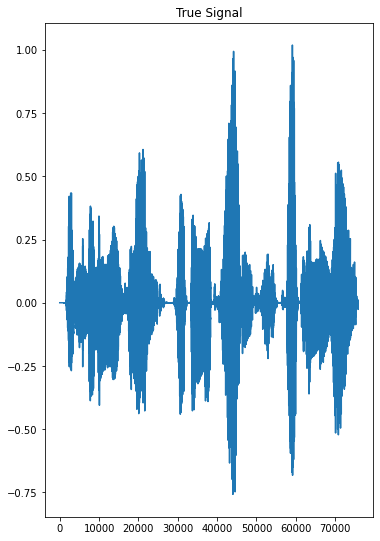

In [ ]:
x = true_signals[7]
X = fake_signals[26]
# ---------------- Params
#	[bic,waxis] = bicoher (y,  nfft, wind, segsamp, overlap)

#nfft = [64, 128, 512, 1024,2048]  
#wind = ['hann', 'hamm']
#segsamp = [64,128,256,512]
#overlap  = [30,50,70]
nfft = [2048]  
wind = ['hann']
segsamp = [32]
overlap  = [50]
subn=2
subp=3
## ---------- Plots -----------------
plt.figure(figsize=(20,20))
for i in range(0, len(nfft)):
  for j in range(0, len(wind)):
    for k in range(0, len(segsamp)):
      for o in range(0, len(overlap)):
        plt.subplot(subn,3,1)
        plt.plot(x)
        plt.title('True Signal')
        subp = 1 + subp
        anglez_x,bic_x,meansx,statistic_x= bicoher(x,nfft[i],wind[j],segsamp[k],overlap[o],3)
        plt.subplot(subn,3,2)
        plt.imshow(20*np.log10(abs(fftshift(bic_x))))
        plt.title('signal x with NFFT= {}'.format(nfft[i]) + ', Window= {}'.format(wind[j]) + ', segsamp= {}'.format(segsamp[k]) + ', overlap= {}'.format(overlap[o]))
        plt.subplot(subn,3,3)
        plt.hist(anglez_x,20)
        plt.subplots_adjust(hspace=0.5)
        plt.subplots_adjust(wspace=0.5)

plt.figure(figsize=(20,20))
for i in range(0, len(nfft)):
  for j in range(0, len(wind)):
    for k in range(0, len(segsamp)):
      for o in range(0, len(overlap)):
          plt.subplot(subn,3,4)
          plt.plot(X)
          plt.title('Fake Signal')
          anglez_X,bic_x,meansX,statistic_X= bicoher(X,nfft[i],wind[j],segsamp[k],overlap[o],3)
          plt.subplot(subn,3,5)
          plt.imshow(20*np.log10(abs(fftshift(bic_x))))
          plt.title('signal X with NFFT= {}'.format(nfft[i]) + ', Window= {}'.format(wind[j]) + ', segsamp= {}'.format(segsamp[k]) + ', overlap= {}'.format(overlap[o]))
          plt.subplot(subn,3,6)
          plt.subplots_adjust(hspace=0.5)
          plt.subplots_adjust(wspace=0.5)
          plt.hist(anglez_X,20)


In [ ]:
all_true_var_ang[3] = statistic_x[0]
all_true_var_bic[3] = statistic_x[1]
all_true_std_ang[3] = statistic_x[2]
all_true_std_bic[3] = statistic_x[3]
all_true_skew_ang[3] = statistic_x[4]
all_true_skew_bic[3] = statistic_x[5]
all_true_kurtosis_ang[3] = statistic_x[6]
all_true_kurtosis_bic[3] = statistic_x[7]

all_fake_var_ang[3] = statistic_X[0]
all_fake_var_bic[3] = statistic_X[1]
all_fake_std_ang[3] = statistic_X[2]
all_fake_std_bic[3] = statistic_X[3]
all_fake_skew_ang[3] = statistic_X[4]
all_fake_skew_bic[3] = statistic_X[5]
all_fake_kurtosis_ang[3] = statistic_X[6]
all_fake_kurtosis_bic[3] = statistic_X[7]

In [ ]:
X = fake_signals[26]
ipd.display(ipd.Audio(X, rate=22050))         # we use idp.Audio to listen to each note

In [ ]:
x = true_signals[7]
ipd.display(ipd.Audio(x, rate=22050))         # we use idp.Audio to listen to each note

In [ ]:
print('var_ang')
print('x = ',statistic_x[0], 'X = ',statistic_X[0])
print('var_bic')
print('x = ',statistic_x[1],  'X = ',statistic_X[1])
print('std_ang' )
print('x = ',statistic_x[2],  'X = ',statistic_X[2])
print('std_bic')
print('x = ',statistic_x[3], 'X = ',statistic_X[3])
print('skew_ang')
print('x  = ',statistic_x[4], 'X = ',statistic_X[4])
print('skew_bic')
print('x = ',statistic_x[5], 'X = ',statistic_X[5])
print('kurtosis_ang')
print('x = ',statistic_x[6], 'X = ',statistic_X[6])
print('kurtosis_bic')
print('x = ',statistic_x[7], 'X = ',statistic_X[7])

var_ang
x =  1.0377126008340097e+67 X =  6.146731633433532e+69
var_bic
x =  2.6301123136132063e-59 X =  4.576917555464985e-62
std_ang
x =  1102.8542038938253 X =  933.6712672074874
std_bic
x =  1.755766284298995e-60 X =  2.5477594004550734e-63
skew_ang
x  =  0.0011880563567865253 X =  0.0004504626869451892
skew_bic
x =  0.0 X =  0.0
kurtosis_ang
x =  -0.5588981450314936 X =  -0.9167467486815819
kurtosis_bic
x =  -3.0 X =  -3.0


# **PLOT**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


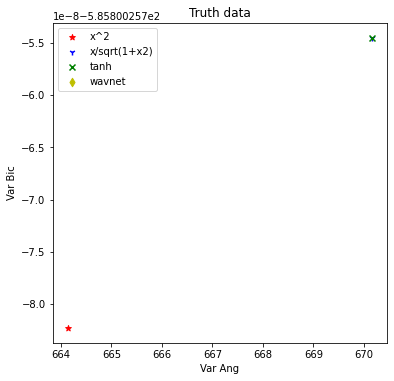

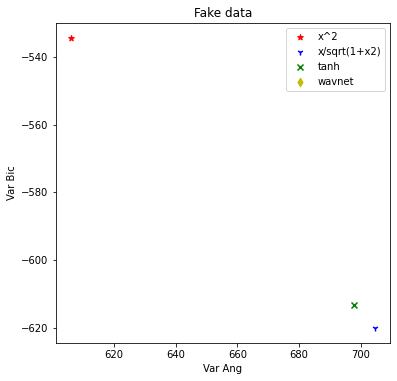

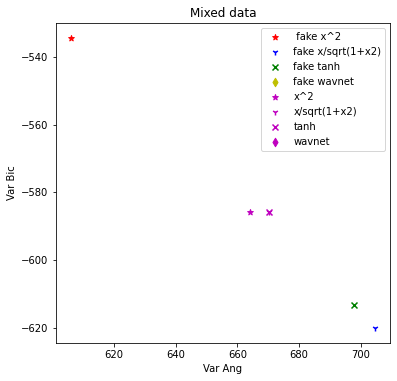

In [ ]:
plt.figure(figsize=(6,20))
plt.subplot(3,1,1)
plt.scatter(10*np.log10(all_true_var_ang[0]),10*np.log10(all_true_var_bic[0]),c='r',marker='*')
plt.scatter(10*np.log10(all_true_var_ang[1]),10*np.log10(all_true_var_bic[1]),c='b',marker='1')
plt.scatter(10*np.log10(all_true_var_ang[2]),10*np.log10(all_true_var_bic[2]),c='g',marker='x')
plt.scatter(10*np.log10(all_true_var_ang[3]),10*np.log10(all_true_var_bic[3]),c='y',marker='d')
plt.title('Truth data')
plt.xlabel('Var Ang')
plt.ylabel('Var Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet'))

plt.figure(figsize=(6,20))
plt.subplot(3,1,2)
plt.scatter(10*np.log10(all_fake_var_ang[0]),10*np.log10(all_fake_var_bic[0]),c='r',marker='*')
plt.scatter(10*np.log10(all_fake_var_ang[1]),10*np.log10(all_fake_var_bic[1]),c='b',marker='1')
plt.scatter(10*np.log10(all_fake_var_ang[2]),10*np.log10(all_fake_var_bic[2]),c='g',marker='x')
plt.scatter(10*np.log10(all_fake_var_ang[3]),10*np.log10(all_fake_var_bic[3]),c='y',marker='d')
plt.title('Fake data')
plt.xlabel('Var Ang')
plt.ylabel('Var Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet'))


plt.figure(figsize=(6,20))
plt.subplot(3,1,3)
plt.scatter(10*np.log10(all_fake_var_ang[0]),10*np.log10(all_fake_var_bic[0]),c='r',marker='*')
plt.scatter(10*np.log10(all_fake_var_ang[1]),10*np.log10(all_fake_var_bic[1]),c='b',marker='1')
plt.scatter(10*np.log10(all_fake_var_ang[2]),10*np.log10(all_fake_var_bic[2]),c='g',marker='x')
plt.scatter(10*np.log10(all_fake_var_ang[3]),10*np.log10(all_fake_var_bic[3]),c='y',marker='d')
plt.scatter(10*np.log10(all_true_var_ang[0]),10*np.log10(all_true_var_bic[0]),c='m',marker='*')
plt.scatter(10*np.log10(all_true_var_ang[1]),10*np.log10(all_true_var_bic[1]),c='m',marker='1')
plt.scatter(10*np.log10(all_true_var_ang[2]),10*np.log10(all_true_var_bic[2]),c='m',marker='x')
plt.scatter(10*np.log10(all_true_var_ang[3]),10*np.log10(all_true_var_bic[3]),c='m',marker='d')
plt.title('Mixed data')
plt.xlabel('Var Ang')
plt.ylabel('Var Bic')
plt.legend((' fake x^2','fake x/sqrt(1+x2)','fake tanh','fake wavnet','x^2','x/sqrt(1+x2)','tanh','wavnet'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


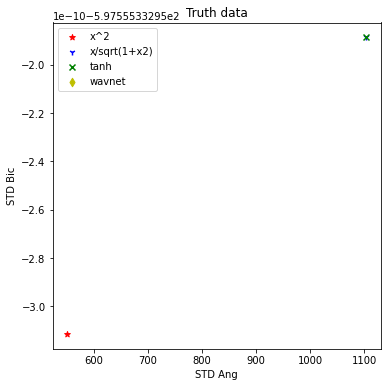

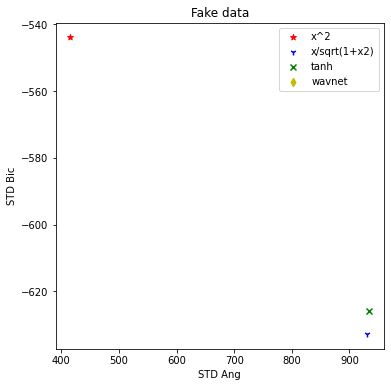

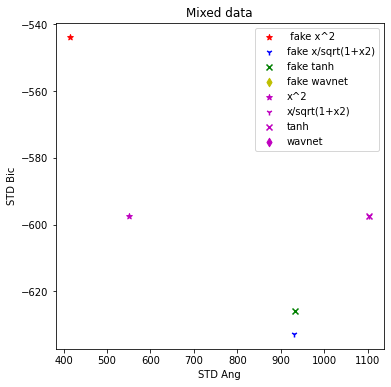

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(all_true_std_ang[0],10*np.log10(all_true_std_bic[0]),c='r',marker = '*')
plt.scatter(all_true_std_ang[1],10*np.log10(all_true_std_bic[1]),c='b',marker = '1')
plt.scatter(all_true_std_ang[2],10*np.log10(all_true_std_bic[2]),c='g',marker = 'x')
plt.scatter(all_true_std_ang[3],10*np.log10(all_true_std_bic[3]),c='y',marker = 'd')
plt.title('Truth data')
plt.xlabel('STD Ang')
plt.ylabel('STD Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet'))

plt.figure(figsize=(20,6))
plt.subplot(1,3,2)
plt.scatter(all_fake_std_ang[0],10*np.log10(all_fake_std_bic[0]),c='r',marker = '*')
plt.scatter(all_fake_std_ang[1],10*np.log10(all_fake_std_bic[1]),c='b',marker = '1')
plt.scatter(all_fake_std_ang[2],10*np.log10(all_fake_std_bic[2]),c='g',marker = 'x')
plt.scatter(all_fake_std_ang[3],10*np.log10(all_fake_std_bic[3]),c='y',marker = 'd')
plt.title('Fake data')
plt.xlabel('STD Ang')
plt.ylabel('STD Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet'))

plt.figure(figsize=(20,6))
plt.subplot(1,3,3)
plt.scatter(all_fake_std_ang[0],10*np.log10(all_fake_std_bic[0]),c='r',marker = '*')
plt.scatter(all_fake_std_ang[1],10*np.log10(all_fake_std_bic[1]),c='b',marker = '1')
plt.scatter(all_fake_std_ang[2],10*np.log10(all_fake_std_bic[2]),c='g',marker = 'x')
plt.scatter(all_fake_std_ang[3],10*np.log10(all_fake_std_bic[3]),c='y',marker = 'd')
plt.scatter(all_true_std_ang[0],10*np.log10(all_true_std_bic[0]),c='m',marker = '*')
plt.scatter(all_true_std_ang[1],10*np.log10(all_true_std_bic[1]),c='m',marker = '1')
plt.scatter(all_true_std_ang[2],10*np.log10(all_true_std_bic[2]),c='m',marker = 'x')
plt.scatter(all_true_std_ang[3],10*np.log10(all_true_std_bic[3]),c='m',marker = 'd')
plt.title('Mixed data')
plt.xlabel('STD Ang')
plt.ylabel('STD Bic')
plt.legend((' fake x^2','fake x/sqrt(1+x2)','fake tanh','fake wavnet','x^2','x/sqrt(1+x2)','tanh','wavnet'))





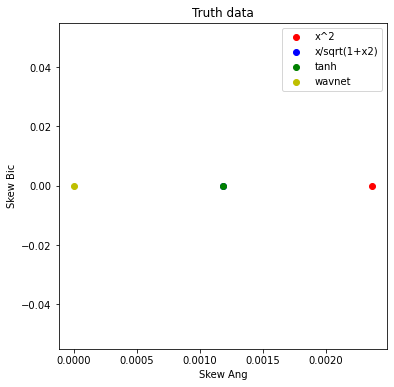

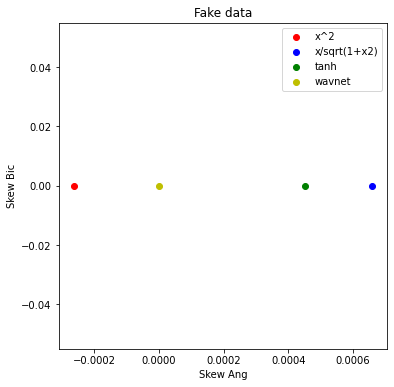

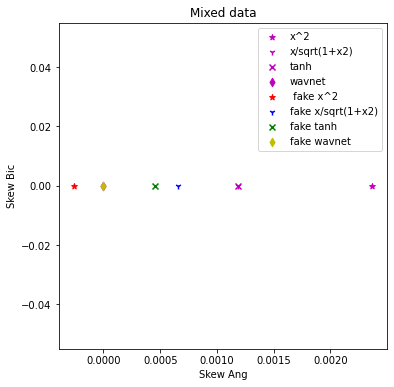

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(all_true_skew_ang[0],all_true_skew_bic[0],c='r')
plt.scatter(all_true_skew_ang[1],all_true_skew_bic[1],c='b')
plt.scatter(all_true_skew_ang[2],all_true_skew_bic[2],c='g')
plt.scatter(all_true_skew_ang[3],all_true_skew_bic[3],c='y')
plt.title('Truth data')
plt.xlabel('Skew Ang')
plt.ylabel('Skew Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet'))

plt.figure(figsize=(20,6))
plt.subplot(1,3,2)
plt.scatter(all_fake_skew_ang[0],all_fake_skew_bic[0],c='r')
plt.scatter(all_fake_skew_ang[1],all_fake_skew_bic[1],c='b')
plt.scatter(all_fake_skew_ang[2],all_fake_skew_bic[2],c='g')
plt.scatter(all_fake_skew_ang[3],all_fake_skew_bic[3],c='y')
plt.title('Fake data')
plt.xlabel('Skew Ang')
plt.ylabel('Skew Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet'))

plt.figure(figsize=(20,6))
plt.subplot(1,3,3)
plt.scatter(all_true_skew_ang[0],all_true_skew_bic[0],c='m',marker ='*')
plt.scatter(all_true_skew_ang[1],all_true_skew_bic[1],c='m',marker ='1')
plt.scatter(all_true_skew_ang[2],all_true_skew_bic[2],c='m',marker ='x')
plt.scatter(all_true_skew_ang[3],all_true_skew_bic[3],c='m',marker ='d')
plt.scatter(all_fake_skew_ang[0],all_fake_skew_bic[0],c='r',marker ='*')
plt.scatter(all_fake_skew_ang[1],all_fake_skew_bic[1],c='b',marker ='1')
plt.scatter(all_fake_skew_ang[2],all_fake_skew_bic[2],c='g',marker ='x')
plt.scatter(all_fake_skew_ang[3],all_fake_skew_bic[3],c='y',marker ='d')
plt.title('Mixed data')
plt.xlabel('Skew Ang')
plt.ylabel('Skew Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet',' fake x^2','fake x/sqrt(1+x2)','fake tanh','fake wavnet'))

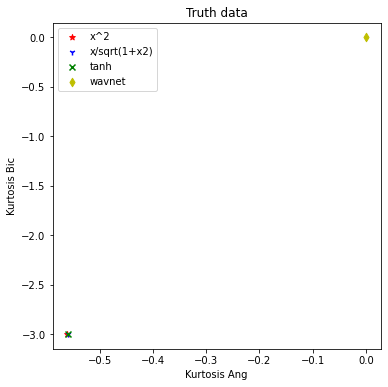

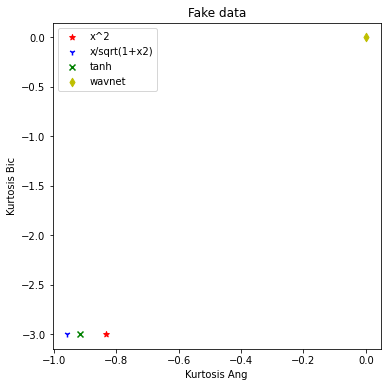

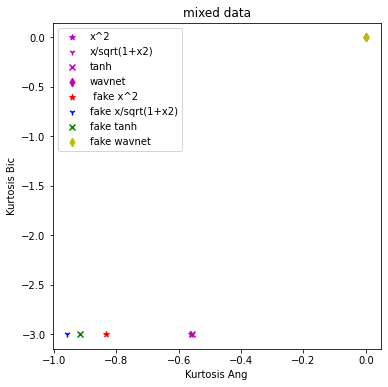

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(all_true_kurtosis_ang[0],all_true_kurtosis_bic[0],c='r',marker = '*')
plt.scatter(all_true_kurtosis_ang[1],all_true_kurtosis_bic[1],c='b',marker = '1')
plt.scatter(all_true_kurtosis_ang[2],all_true_kurtosis_bic[2],c='g',marker = 'x')
plt.scatter(all_true_kurtosis_ang[3],all_true_kurtosis_bic[3],c='y',marker = 'd')
plt.title('Truth data')
plt.xlabel('Kurtosis Ang')
plt.ylabel('Kurtosis Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet'))

plt.figure(figsize=(20,6))
plt.subplot(1,3,2)
plt.scatter(all_fake_kurtosis_ang[0],all_fake_kurtosis_bic[0],c='r',marker = '*')
plt.scatter(all_fake_kurtosis_ang[1],all_fake_kurtosis_bic[1],c='b',marker = '1')
plt.scatter(all_fake_kurtosis_ang[2],all_fake_kurtosis_bic[2],c='g',marker = 'x')
plt.scatter(all_fake_kurtosis_ang[3],all_fake_kurtosis_bic[3],c='y', marker = 'd')
plt.title('Fake data')
plt.xlabel('Kurtosis Ang')
plt.ylabel('Kurtosis Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet'))

plt.figure(figsize=(20,6))
plt.subplot(1,3,3)
plt.scatter(all_true_kurtosis_ang[0],all_true_kurtosis_bic[0],c='m',marker = '*')
plt.scatter(all_true_kurtosis_ang[1],all_true_kurtosis_bic[1],c='m',marker = '1')
plt.scatter(all_true_kurtosis_ang[2],all_true_kurtosis_bic[2],c='m',marker = 'x')
plt.scatter(all_true_kurtosis_ang[3],all_true_kurtosis_bic[3],c='m',marker = 'd')
plt.scatter(all_fake_kurtosis_ang[0],all_fake_kurtosis_bic[0],c='r',marker = '*')
plt.scatter(all_fake_kurtosis_ang[1],all_fake_kurtosis_bic[1],c='b',marker = '1')
plt.scatter(all_fake_kurtosis_ang[2],all_fake_kurtosis_bic[2],c='g',marker = 'x')
plt.scatter(all_fake_kurtosis_ang[3],all_fake_kurtosis_bic[3],c='y',marker = 'd')
plt.title('mixed data')
plt.xlabel('Kurtosis Ang')
plt.ylabel('Kurtosis Bic')
plt.legend(('x^2','x/sqrt(1+x2)','tanh','wavnet',' fake x^2','fake x/sqrt(1+x2)','fake tanh','fake wavnet'))


